**Dados**: train_df.csv
- Tabela de dados de empresa de ecommerce com mais de 130 mil avaliações de clientes. A base oferece informações sobre o perfil do revisor, como sexo, idade e localização geográfica.
    - y label column: overall_rating

## Próximos passos:

**Entregáveis**: link para repositório com ao menos os seguintes arquivos:
- README.md
- notebook da solução
- source-code
- requirements.txt

**Avaliação do Notebook**: Serão utilizados os seguintes critérios para avaliação da solução:
- estruturação do experimento
- organização do código
- exploração e análise dos dados
- solução utilizada
- resultado obtido

**Entrevista**: Após o envio da solução do problema proposto, iremos agendar uma entrevista para discutir a solução adotada, onde iremos fazer perguntas mais aprofundadas sobre um ou mais dos tópicos abaixo:
- machine learning
- programação
- design de sistema
- aplicação ao busines

In [1]:
# # Load the Drive helper and mount.
# from google.colab import drive

# # This will prompt for authorization.
# drive.mount('/content/drive')

In [0]:
!pip install category_encoders
!pip install Unidecode

In [6]:
import itertools, os, sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import missingno as msgn
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from category_encoders import TargetEncoder

sys.path.append('../src')

from utils import plot_confusion_matrix
matplotlib.rcParams['figure.figsize'] = (10,6)


In [3]:
%%bash 

# ls './drive/My Drive/Colab Notebooks/letrus/data'

### Utils

In [4]:
def replace_missing_with_mean(df, feature, label_name):
  "subtititui os missing values pela média do da coluna agrupada pelo target"
  
  def _replace_missing(x):
    mean = {}

    return mean[x]

  df_ = df.copy()
  feature_ = '%s_num' % feature
  df_[feature_] = pd.to_numeric(df_[feature], errors='coerce')
  df_[feature].loc[df[feature_].isna()] = df_[label_name].loc[df_[feature_].isna()].apply(lambda x: _replace_missing(x))

  return df_[feature]

### Loading data

In [7]:
df = pd.read_csv('../data/train_df.csv', sep=",")
print(df.shape)
df.head()

(105898, 15)


index      submission_date  \
0   95851  2018-04-20 11:56:28   
1  115536  2018-05-10 18:56:36   
2    1254  2018-01-02 07:02:48   
3   86792  2018-04-11 16:45:45   
4   35543  2018-02-02 16:30:23   

                                         reviewer_id product_id  \
0  c951f3a4511b554a1f34330903c320f34cfccbdf8de357...  111586438   
1  21da6d1c6d022a5c67da402d3082c7c438660f4252b7c3...   19399940   
2  eaf2f059cbb702e377bf95ac998aa4365f851937a3b419...   22747780   
3  e5bb0709d14bc4a00aeaeb1f111616e69f57239dff7da6...   22857850   
4  420a3ab1adf3c6010d491c8def04e19b1439ed01df7038...  132207708   

                                        product_name product_brand  \
0     Depilador Elétrico Philips Satinelle HP6403/30       philips   
1  Hidratante Corporal Dior Addict Body Mist Femi...           NaN   
2  Controle Com Fio Para Xbox 360 Slim / Fat E Pc...           NaN   
3  Kit Edredom + Lençol Aconchego Dupla Face Casa...           NaN   
4  Smartphone Motorola Moto E4 Dual Chip Android ...      motorola   

         site_category_lv1   site_category_lv2  \
0      Beleza e Perfumaria           Depilação   
1      Beleza e Perfumaria  Tratamento de Pele   
2                    Games            Xbox 360   
3       Cama, Mesa e Banho             Edredom   
4  Celulares e Smartphones          Smartphone   

                            review_title recommend_to_a_friend  \
0                              Depilador                   Yes   
1                         Cheiro de rica                   Yes   
2                            Bom produto                   Yes   
3  Nao recebi onprofuto e nem satisfacao                    No   
4                   Excelente aquisição!                   Yes   

                                         review_text  reviewer_birth_year  \
0  Muito eficiente e prático! Depilação rápida em...               1978.0   
1  Adoro o perfume que fica na pele, ele não é um...               1986.0   
2  funciona o que é importante bom produto o text...               1978.0   
3  Gostaria de saber da minha entrega ate hoje na...               1969.0   
4  Entrega super rápida!  Quando da compra tive c...               1965.0   

  reviewer_gender reviewer_state  overall_rating  
0               F             ES               5  
1               F             SP               5  
2               M             ES               3  
3               F             RJ               1  
4               M             PE               4

In [8]:
df.sample(n=1).T

38828
index                                                              93320
submission_date                                      2018-04-18 07:19:46
reviewer_id            420a1c7079233b53d95cee76573417126b1714a6f6032f...
product_id                                                     132569266
product_name           Smartphone Motorola Moto X4 Dual Cam Android 7...
product_brand                                                        NaN
site_category_lv1                                Celulares e Smartphones
site_category_lv2                                             Smartphone
review_title                                                 Satisfeito!
recommend_to_a_friend                                                Yes
review_text            Muito satisfeito com o produto e a pontualidad...
reviewer_birth_year                                                 1981
reviewer_gender                                                        M
reviewer_state                                                        ES
overall_rating                                                         4

### Missing values

In [9]:
nulls = df.isna().mean()
nulls

index                    0.000000
submission_date          0.000000
reviewer_id              0.000000
product_id               0.000000
product_name             0.000614
product_brand            0.691175
site_category_lv1        0.000028
site_category_lv2        0.030331
review_title             0.000000
recommend_to_a_friend    0.000094
review_text              0.000000
reviewer_birth_year      0.045261
reviewer_gender          0.031313
reviewer_state           0.030284
overall_rating           0.000000
dtype: float64

In [10]:
df['product_brand'].value_counts()

samsung             4841
lg                  2347
philco              2158
cadence             1117
mondial             1023
                    ... 
vigil games            1
jolitex ternille       1
oops                   1
repelex                1
zero acucar            1
Name: product_brand, Length: 985, dtype: int64

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


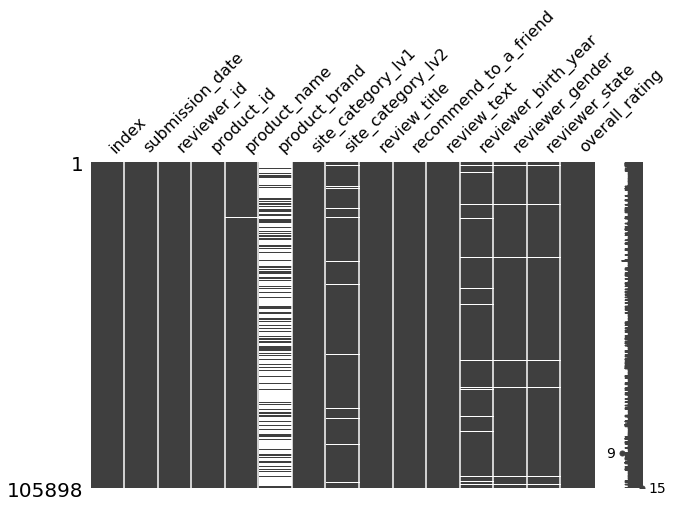

In [11]:
msgn.matrix(df, figsize=(10,6))
plt.tight_layout()

In [0]:
# df.dropna(how='any', inplace=True)
# df.shape

### Data types

In [12]:
label_name = 'overall_rating'

In [13]:
cat_features_ = df.select_dtypes(include=[object]).columns
print(cat_features_)
cat_features = ['product_id', 'product_name',
                'product_brand', 'site_category_lv1', 'site_category_lv2',
                'recommend_to_a_friend','reviewer_gender', 'reviewer_state']
cat_features

Index(['submission_date', 'reviewer_id', 'product_id', 'product_name',
       'product_brand', 'site_category_lv1', 'site_category_lv2',
       'review_title', 'recommend_to_a_friend', 'review_text',
       'reviewer_gender', 'reviewer_state'],
      dtype='object')


['product_id',
 'product_name',
 'product_brand',
 'site_category_lv1',
 'site_category_lv2',
 'recommend_to_a_friend',
 'reviewer_gender',
 'reviewer_state']

In [14]:
num_features = df.select_dtypes(include=[np.number]).columns
print(num_features)

Index(['index', 'reviewer_birth_year', 'overall_rating'], dtype='object')


In [15]:
text_features = ['review_title', 'review_text']
df[text_features].head()

review_title  \
0                              Depilador   
1                         Cheiro de rica   
2                            Bom produto   
3  Nao recebi onprofuto e nem satisfacao   
4                   Excelente aquisição!   

                                         review_text  
0  Muito eficiente e prático! Depilação rápida em...  
1  Adoro o perfume que fica na pele, ele não é um...  
2  funciona o que é importante bom produto o text...  
3  Gostaria de saber da minha entrega ate hoje na...  
4  Entrega super rápida!  Quando da compra tive c...

### Target

In [16]:
chart = df['overall_rating'].value_counts()
print(chart)
chart.sort_index(inplace=True)
chart.plot(kind='bar')

5    38315
4    25855
1    21998
3    13004
2     6726
Name: overall_rating, dtype: int64


### Categorical


#### Bivariate analysis

In [17]:
cat_features

['product_id',
 'product_name',
 'product_brand',
 'site_category_lv1',
 'site_category_lv2',
 'recommend_to_a_friend',
 'reviewer_gender',
 'reviewer_state']

In [18]:
feature ='reviewer_state'
df.groupby(feature).mean()['overall_rating'].plot(kind='bar')
plt.ylabel("%s mean" % label_name)
plt.title("%s x overall rate mean" % feature)
plt.legend()

In [19]:
feature ='reviewer_gender'
df.groupby(feature).mean()['overall_rating'].plot(kind='bar')
plt.ylabel("%s mean" % label_name)
plt.title("%s x overall rate mean" % feature)
plt.legend()

In [26]:
feature ='recommend_to_a_friend'
print(df[feature].unique())
df.groupby(feature).mean()['overall_rating'].plot(kind='bar')
plt.ylabel("%s mean" % label_name)
plt.title("%s x overall rate mean" % feature)
plt.legend()

['Yes' 'No' nan]


#### reducing cardinality

In [27]:
def reduce_cardinality(df, feature, threshold = 0.05):
  "group same class with less than %5 of frequence as the same special class"

  df_ = df[feature].value_counts() / df.shape[0]
  map_values = {feature:feature if pct > threshold else 'outro' for feature, pct in df_.to_dict().items()}
  df[feature] =  df[feature].map(map_values) 

  return df

In [31]:
cat_features

['product_id',
 'product_name',
 'product_brand',
 'site_category_lv1',
 'site_category_lv2',
 'recommend_to_a_friend',
 'reviewer_gender',
 'reviewer_state']

54


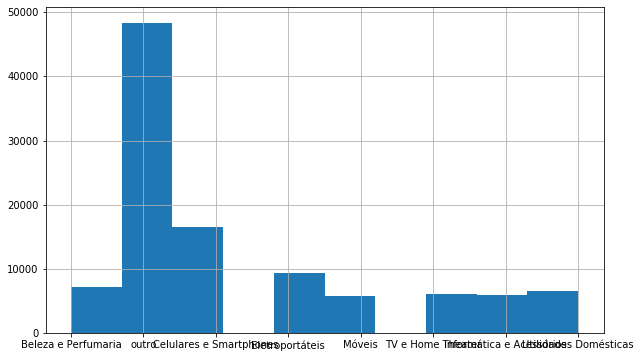

In [35]:
feature = 'site_category_lv1'
print(len(df[feature].unique()))

df_ = df.copy()
df_ = reduce_cardinality(df_, feature)
df_[feature].hist()


#### Categorical to numeric

In [36]:
 
def replace_cat_by_mean(df, feature, label_name):
  " replace the class with its mean grouped by target "
  
  map_values = df.groupby(feature).mean()[label_name].to_dict()
  return df[feature].map(map_values)

In [37]:
feature = 'product_name'
df_ = df.copy()
feature_ = "%s_num" % feature
df_[feature_] = replace_cat_by_mean(df, feature, label_name)
df_[[feature, feature_]].head()

product_name  product_name_num
0     Depilador Elétrico Philips Satinelle HP6403/30          4.294737
1  Hidratante Corporal Dior Addict Body Mist Femi...          5.000000
2  Controle Com Fio Para Xbox 360 Slim / Fat E Pc...          2.250000
3  Kit Edredom + Lençol Aconchego Dupla Face Casa...          1.000000
4  Smartphone Motorola Moto E4 Dual Chip Android ...          3.823529

In [42]:
to_numeric_encode = ['product_name','product_id', 'product_brand','site_category_lv1',
                    'site_category_lv2', 'recommend_to_a_friend', 'reviewer_gender',
                     'reviewer_state']

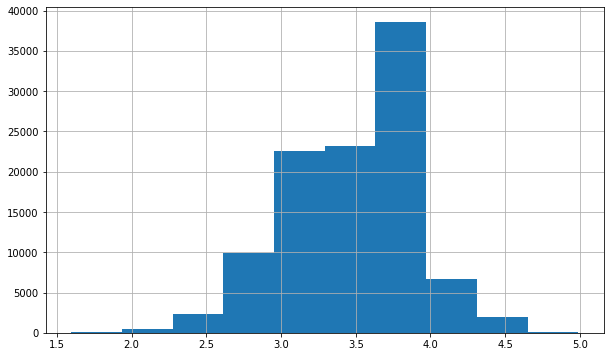

In [43]:
feature = 'site_category_lv2'

df_ = df.copy()

encoder = TargetEncoder()

df_[feature] = encoder.fit_transform(df_[feature], df_[label_name])

df_[feature].hist()

In [44]:
print(to_numeric_encode)
df_ = df.copy()

encoder = TargetEncoder()

df_[to_numeric_encode] = encoder.fit_transform(df_[to_numeric_encode], df_[label_name])

df_[to_numeric_encode].head()

['product_name', 'product_id', 'product_brand', 'site_category_lv1', 'site_category_lv2', 'recommend_to_a_friend', 'reviewer_gender', 'reviewer_state']


product_name  product_id  product_brand  site_category_lv1  \
0      4.294737    4.294737       3.851703           3.507477   
1      3.488801    3.488801       3.371205           3.507477   
2      2.250000    2.250000       3.371205           3.523358   
3      1.118034    1.118034       3.371205           3.158163   
4      3.823529    3.823529       3.593716           3.721349   

   site_category_lv2  recommend_to_a_friend  reviewer_gender  reviewer_state  
0           3.656535               4.272740         3.517542        3.465708  
1           3.567901               4.272740         3.517542        3.505200  
2           3.445230               4.272740         3.448064        3.465708  
3           2.756757               1.398851         3.517542        3.390745  
4           3.902122               4.272740         3.448064        3.540282

#### len title and review text

In [45]:
df_['len_review_text'] = df['review_text'].apply(lambda x: len(x.split(" ")))
df_['len_review_title'] = df['review_title'].apply(lambda x: len(x.split(" ")))
df_[['len_review_text', 'len_review_title']].head()

len_review_text  len_review_title
0               23                 1
1               25                 3
2               24                 2
3               12                 6
4               65                 2

In [46]:
def group_by(df, feature, filter_column, q=10):
  chart = df.copy() 
  bin_column = '%s_bins' % feature
  chart[bin_column] = pd.qcut(df[feature], q=10)
  chart = chart.groupby(bin_column).mean()[filter_column]
  chart = chart.reset_index()
  chart[bin_column] = chart[bin_column].apply(lambda x: "{:.2f} - {:.2f}".format(x.left, x.right))
  
  return chart.set_index(bin_column)

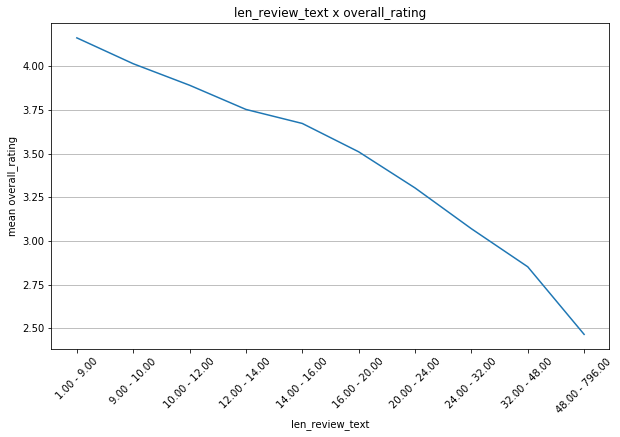

In [47]:
feature = 'len_review_text'

chart = group_by(df_, feature, filter_column=label_name)
plt.plot(chart.index, chart[label_name])
plt.title("%s x %s" % (feature, label_name))
plt.ylabel('mean %s' % label_name)
plt.xlabel(feature)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.grid(axis='y')

Text(0, 0.5, 'len review text mean')

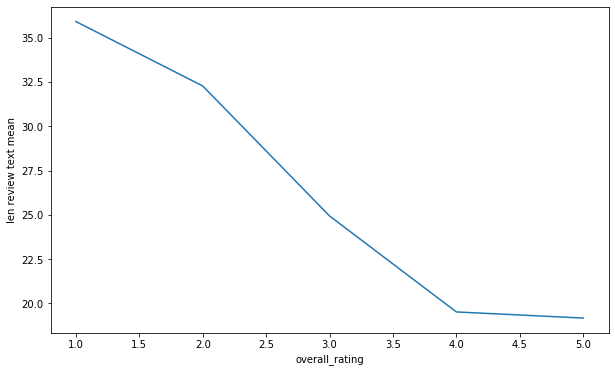

In [60]:
df_.groupby('overall_rating').mean()['len_review_text'].plot()
plt.ylabel("len review text mean")

Text(0, 0.5, 'len review title mean')

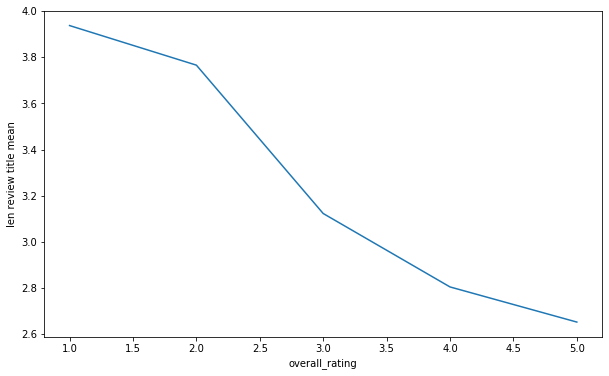

In [61]:
df_.groupby('overall_rating').mean()['len_review_title'].plot()
plt.ylabel("len review title mean")

#### encoding review title and text with naive bayes

In [62]:
import nltk
from unidecode import unidecode
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

def remove_accentuation(x):
  return unidecode(x)

def clear_text(x):
  x = x.strip().lower()
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  x = tokenizer.tokenize(x)  
  x = " ".join(x)  
  x = remove_accentuation(x)  
  return x

def get_stopwords():
  stopwords = nltk.corpus.stopwords.words('portuguese')
  return stopwords

def get_noise_words(df, feature):
  text = clear_text(" ".join(df[feature].values))
  vocab = pd.Series(text.split(" "))
  counts = vocab.value_counts()
  noise_words = counts[counts == 1].index

  return noise_words

def remove_noise_words(text, noise_words):
  x = " ".join([word for word in text.split(" ") if not word in noise_words])
  return x

def remove_stopwords(text, stopwords):
  x =  " ".join([word for word in text.split(" ") if not word in stopwords])
  return x

def naive_bayes_encode(df, feature, label_name):
  # df_ = df.copy()
  X = df[feature].apply(lambda x: clear_text(x))
  y = df[label_name]

  vect = CountVectorizer().fit(X)
  X_vectorized = vect.transform(X)

  nbclf = MultinomialNB(alpha = 0.1)
  nbclf.fit(X_vectorized, y)
  y_pred = nbclf.predict(X_vectorized)
  
  return y_pred

In [63]:
for col in text_features:
  df_[col] = naive_bayes_encode(df, col, label_name)

df_[text_features].head()

review_title  review_text
0             5            5
1             5            5
2             4            3
3             1            1
4             5            4

### Correlations

In [66]:
final_columns = ['product_id', 'product_brand', 'site_category_lv1', 
                 'site_category_lv2', 'recommend_to_a_friend', 
                 'review_title', 'review_text',
                 'len_review_text', 'len_review_title',
                 'overall_rating']

df_[final_columns].head()

product_id  product_brand  site_category_lv1  site_category_lv2  \
0    4.294737       3.851703           3.507477           3.656535   
1    3.488801       3.371205           3.507477           3.567901   
2    2.250000       3.371205           3.523358           3.445230   
3    1.118034       3.371205           3.158163           2.756757   
4    3.823529       3.593716           3.721349           3.902122   

   recommend_to_a_friend  review_title  review_text  len_review_text  \
0               4.272740             5            5               23   
1               4.272740             5            5               25   
2               4.272740             4            3               24   
3               1.398851             1            1               12   
4               4.272740             5            4               65   

   len_review_title  overall_rating  
0                 1               5  
1                 3               5  
2                 2               3  
3                 6               1  
4                 2               4

Text(0.5, 1, 'Pearson correlation - linear relations')

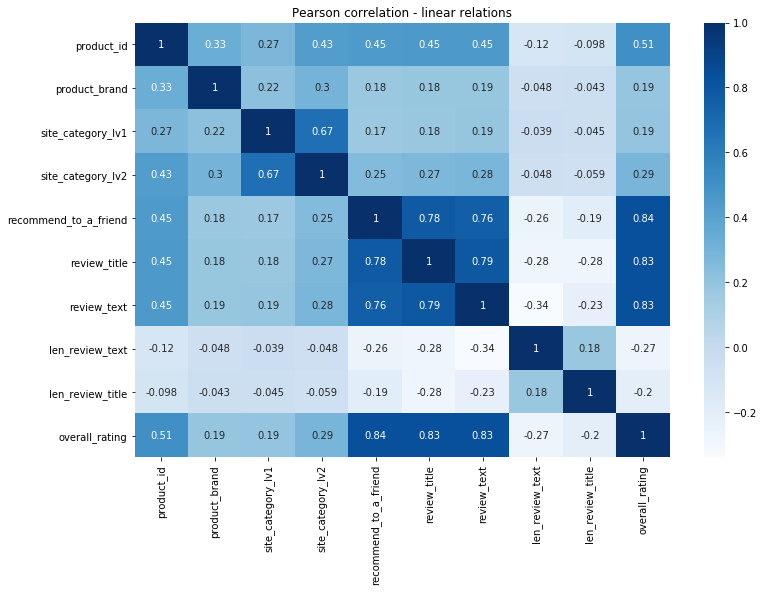

In [68]:
plt.figure(figsize=(12, 8))
corr = df_[final_columns].corr()
# corr = corr[(corr >= 0.1) | (corr <= -0.1)]
sns.heatmap(
    corr,
    annot=True,
    cmap='Blues',
)

plt.title("Pearson correlation - linear relations")

### Text features

#### formatig text

In [69]:
import re
import string
import nltk
from sklearn.feature_extraction.stop_words import _stop_words
from unidecode import unidecode
nltk.download('stopwords')

def remove_accentuation(x):
  return unidecode(x)

def clear_text(x):
  x = x.strip().lower()
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  x = tokenizer.tokenize(x)  
  x = " ".join(x)  
  x = remove_accentuation(x)  
  return x

def get_stopwords():
  stopwords = nltk.corpus.stopwords.words('portuguese')
  return stopwords

def get_noise_words(df, feature):
  text = clear_text(" ".join(df[feature].values))
  vocab = pd.Series(text.split(" "))
  counts = vocab.value_counts()
  noise_words = counts[counts == 1].index

  return noise_words

def remove_noise_words(text, noise_words):
  x = " ".join([word for word in text.split(" ") if not word in noise_words])
  return x

def remove_stopwords(text, stopwords):
  x =  " ".join([word for word in text.split(" ") if not word in stopwords])
  return x

def tranform_text(df, feature, label_name):

  X = df[feature].apply(lambda x: clear_text(x))
  y = df[label_name]

  vect = CountVectorizer().fit(X)
  X_vectorized = vect.transform(X)

  nbclf = MultinomialNB(alpha = 0.1)
  nbclf.fit(X_vectorized, y)
  y_pred = nbclf.predict(X_vectorized)
  
  return y_pred

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Naive Bayes

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

print(text_features)
# stopwords = get_stopwords()
# noise_words = get_noise_words(df, feature)

X = df['review_text'].apply(lambda x: clear_text(x))

y = df[label_name]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

['review_title', 'review_text']
(105898,)
(105898,)
(79423,)
(79423,)
(26475,)
(26475,)


In [89]:
vect = CountVectorizer().fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

nbclf = MultinomialNB(alpha = 0.8)
nbclf.fit(X_train_vectorized, y_train)

y_pred = nbclf.predict(vect.transform(X_test))
y_score = nbclf.predict_proba(vect.transform(X_test))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.70      0.84      0.76      5517
           2       0.29      0.17      0.21      1676
           3       0.34      0.27      0.30      3260
           4       0.43      0.32      0.37      6544
           5       0.62      0.75      0.68      9478

    accuracy                           0.56     26475
   macro avg       0.47      0.47      0.46     26475
weighted avg       0.53      0.56      0.54     26475



In [90]:
from sklearn.metrics import f1_score
recall = f1_score(y_test, y_pred, average = 'weighted')
print("recall: ", recall)

recall:  0.5427442561642223


[1 2 3 4 5]
Confusion matrix, without normalization
Normalized confusion matrix


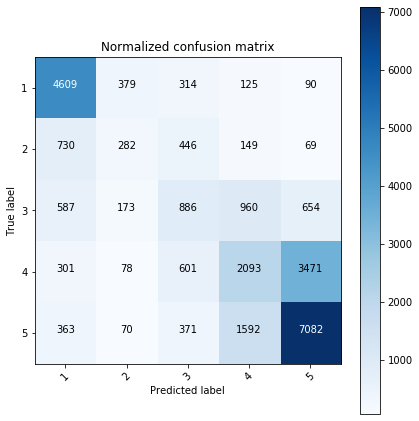

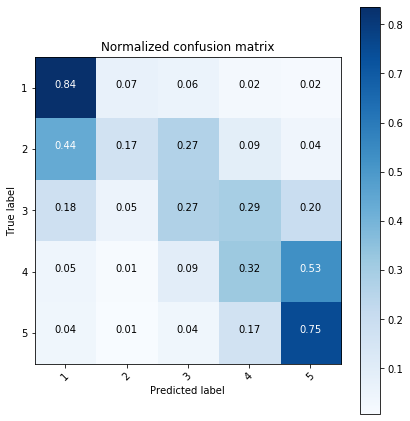

In [91]:
class_names = np.sort(df[label_name].unique())
print(class_names)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Normalized confusion matrix')

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [111]:
y_test = y_test.values

In [123]:
mask = (y_pred == 1) & (y_test == 5)
result = pd.DataFrame(X_test[mask].copy())
 #y_pred != y_test
result['y_pred'] = y_pred[mask]
result['y_test'] = y_test[mask]
print(result.shape)

(363, 3)


In [125]:
for text, pred, actual in result.sample(n=5).values:
    print("review:", text)
    print("pred: ", pred)
    print("actual: ", actual)
    print()

review: pq essa diferenca de preco gritante mim cobraram duas vezes o valor e o produto r horrivel desumano mim cobrar o valor de 2 kits
pred:  1
actual:  5

review: o produto e excelente veio original conforme descrito mas a entrega foi pessima tive que entrar em contato com a americanas para verificar a situacao
pred:  1
actual:  5

review: o produto e de qualidade e muito bom porem o atendimento para devolucao e pessimo horrivel nunca mais compra nada
pred:  1
actual:  5

review: gostaria de saber como faco pra comprar o produto nao e entregue no meu cep alguem passou pela mesma situacao discriminacao com o sul um produto desta qualidade por este valor e nao e entregue aqui se alguem puder me ajudar favor comentar sera que posso usar o fundo de garantia
pred:  1
actual:  5

review: nao existe nada melhor do q vc sair e nao ter q se preocupar em ficar sem bateria no momento q mais precisa agora recarrego meu celular a cada dois dias
pred:  1
actual:  5



### Feature selection

In [126]:
print(final_columns)
# df_ = df_[final_columns]
print(df_.shape)
df_.head()

['product_id', 'product_brand', 'site_category_lv1', 'site_category_lv2', 'recommend_to_a_friend', 'review_title', 'review_text', 'len_review_text', 'len_review_title', 'overall_rating']
(105898, 17)


index      submission_date  \
0   95851  2018-04-20 11:56:28   
1  115536  2018-05-10 18:56:36   
2    1254  2018-01-02 07:02:48   
3   86792  2018-04-11 16:45:45   
4   35543  2018-02-02 16:30:23   

                                         reviewer_id  product_id  \
0  c951f3a4511b554a1f34330903c320f34cfccbdf8de357...    4.294737   
1  21da6d1c6d022a5c67da402d3082c7c438660f4252b7c3...    3.488801   
2  eaf2f059cbb702e377bf95ac998aa4365f851937a3b419...    2.250000   
3  e5bb0709d14bc4a00aeaeb1f111616e69f57239dff7da6...    1.118034   
4  420a3ab1adf3c6010d491c8def04e19b1439ed01df7038...    3.823529   

   product_name  product_brand  site_category_lv1  site_category_lv2  \
0      4.294737       3.851703           3.507477           3.656535   
1      3.488801       3.371205           3.507477           3.567901   
2      2.250000       3.371205           3.523358           3.445230   
3      1.118034       3.371205           3.158163           2.756757   
4      3.823529       3.593716           3.721349           3.902122   

   review_title  recommend_to_a_friend  review_text  reviewer_birth_year  \
0             5               4.272740            5               1978.0   
1             5               4.272740            5               1986.0   
2             4               4.272740            3               1978.0   
3             1               1.398851            1               1969.0   
4             5               4.272740            4               1965.0   

   reviewer_gender  reviewer_state  overall_rating  len_review_text  \
0         3.517542        3.465708               5               23   
1         3.517542        3.505200               5               25   
2         3.448064        3.465708               3               24   
3         3.517542        3.390745               1               12   
4         3.448064        3.540282               4               65   

   len_review_title  
0                 1  
1                 3  
2                 2  
3                 6  
4                 2

In [128]:
# feature selection usando correlação

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

fs = SelectKBest(score_func=f_classif, k='all')
print(label_name)
X = df_[final_columns].drop(label_name, axis=1).values
y = df_[label_name].values

X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

overall_rating
(105898, 9)


In [129]:
features = pd.DataFrame()
features['feature'] = final_columns[:-1]
features['score'] = fs.scores_
features.sort_values(by='score', ascending=False, inplace=True)
features['score_norm'] = (features['score'] - features['score'].min() + 1e-4)/(features['score'].max() -  features['score'].min())
features.set_index('feature')['score']

feature
recommend_to_a_friend    107363.839665
review_title              68736.741740
review_text               63767.502344
product_id                 9181.946104
site_category_lv2          2416.511280
len_review_text            2258.296151
len_review_title           1202.266797
site_category_lv1          1067.799329
product_brand              1065.423015
Name: score, dtype: float64